In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

# NLP
import re
import string
import html
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

# KERAS / TF
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Bidirectional, concatenate, \
                         CuDNNLSTM, CuDNNGRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, \
                         Flatten, GRU
from keras.layers.embeddings import Embedding
print(K.tensorflow_backend._get_available_gpus())

# Flags
balance_dataset = False              # If true, it under-samples the training dataset to get same amount of labels
use_pretrained_embeddings = True     # If true, it enables the use of GloVe pre-trained Twitter word-embeddings

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acamb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acamb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# K.tensorflow_backend.

##### ROC AUC & macro-F1 score Printing Callback

In [2]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

class ROC_F1(Callback):
    def __init__(self, validation_data=(), training_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_train, self.y_train = training_data
        self.f1s_train = []
        self.f1s_val = []
        self.aucs_train = []
        self.aucs_val = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred_train = np.round(self.model.predict(self.X_train, verbose=0))
            y_pred_val   = np.round(self.model.predict(self.X_val, verbose=0))

            auc_train = roc_auc_score(self.y_train, y_pred_train)
            auc_val   = roc_auc_score(self.y_val, y_pred_val)
            f1_train = f1_score(self.y_train, y_pred_train, average='macro')
            f1_val   = f1_score(self.y_val, y_pred_val, average='macro')
            
            self.aucs_train.append(auc_train)
            self.aucs_val.append(auc_val)
            self.f1s_val.append(f1_val)
            self.f1s_train.append(f1_train)
            
            print("     - LR: {:0.5f} train_auc: {:.4f} - train_F1: {:.4f} - val_auc: {:.4f} - val_F1: {:.4f}".format(K.eval(self.model.optimizer.lr), auc_train, f1_train, auc_val, f1_val))
        if epoch % 1 == 0:
            height = 3.5;    width = height*4
            plt.figure(figsize=(width,height))
            plt.plot(self.f1s_train, label="Train F1")
            plt.plot(self.f1s_val, label="Validation F1")
            plt.xlim([0,50]); plt.xticks(list(range(50)));   plt.grid(True);   plt.legend()
            plt.title("F1-score", fontsize=15)
            plt.show()
        print("\n\n")

##### Tweet Processing Function

In [3]:
def process_tweet(tweet, remove_USER_URL=True, remove_punctuation=True, remove_stopwords=True, remove_HTMLentities=True, remove_hashtags=True, appostrophe_handling=True, lemmatize=True, trial=False):
    """
    This function receives tweets and returns clean word-list
    """
    ### Handle USERS and URLS ################################################
    if remove_USER_URL:
        if trial:
            tweet = re.sub(r'@\w+ ?', '', tweet)
            tweet = re.sub(r'http\S+', '', tweet)
        else:
            tweet = re.sub(r"@USER", "<>", tweet)
            tweet = re.sub(r"URL", "", tweet)
    else:
        if trial:
            tweet = re.sub(r'@\w+ ?', '<usertoken> ', tweet)
            tweet = re.sub(r'http\S+', '<urltoken> ', tweet)
        else:
            tweet = re.sub(r"@USER", "<usertoken>", tweet)
            tweet = re.sub(r"URL", "<urltoken>", tweet)
    
    ### Remove HTML Entities #################################################
    if remove_HTMLentities:
        tweet = html.unescape(tweet)
    
    ### REMOVE HASHTAGS? #####################################################
    if remove_hashtags:
        tweet = re.sub(r'#\w+ ?', '', tweet)
    
    ### Convert to lower case: Hi->hi, MAGA -> maga ##########################
    tweet = tweet.lower()
    
    ### Cleaning: non-ASCII filtering, some appostrophes, separation #########
    tweet = re.sub(r"’", r"'", tweet)
    tweet = re.sub(r"[^A-Za-z0-9'^,!.\/+-=@]", " ", tweet)
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
#     tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", " ! ", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ^ ", tweet)
    tweet = re.sub(r"\+", " + ", tweet)
    tweet = re.sub(r"\-", " - ", tweet)
    tweet = re.sub(r"\=", " = ", tweet)
    tweet = re.sub(r"(\d+)(k)", r"\g<1>000", tweet)
    tweet = re.sub(r":", " : ", tweet)
    tweet = re.sub(r" e g ", " eg ", tweet)
    tweet = re.sub(r" b g ", " bg ", tweet)
    tweet = re.sub(r" u s ", " american ", tweet)
    tweet = re.sub(r"\0s", "0", tweet)
    tweet = re.sub(r" 9 11 ", "911", tweet)
    tweet = re.sub(r"e - mail", "email", tweet)
    tweet = re.sub(r"j k", "jk", tweet)
    tweet = re.sub(r"\s{2,}", " ", tweet)

    ### Remove Punctuation ###################################################
    if remove_punctuation:
        translator = str.maketrans('', '', ''.join(list(set(string.punctuation) - set("'"))))
        tweet = tweet.translate(translator)
    
    # Tokenize sentence for further word-level processing
    tokenizer  = TweetTokenizer()
    words = tokenizer.tokenize(tweet)
    
    ### Apostrophe handling:    you're   -> you are  ########################
    APPO = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "didn't" : "did not", "doesn't" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am", "isn't" : "is not", "it's" : "it is", "it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not", "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "that's" : "that is", "there's" : "there is", "they'd" : "they would", "they'll" : "they will", "they're" : "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not", "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is", "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not", "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are", "wasn't": "was not", "we'll":" will", "didn't": "did not"}
    if appostrophe_handling:
        words = [APPO[word] if word in APPO else word for word in words]
    
    tweet = ' '.join(words)
    words = tokenizer.tokenize(tweet)
    
    ### Convert to lower case: Hi->hi, MAGA -> maga ##########################
    
    ### Lemmatisation:          drinking -> drink ###########################
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word, "v") for word in words]
    
    ### Remove stop words:      is, that, the, ... ##########################
    if remove_stopwords:
        eng_stopwords = set(stopwords.words("english"))
        words = [w for w in words if not w in eng_stopwords]
        
    clean_tweet = " ".join(words)
    clean_tweet = re.sub("  "," ",clean_tweet)
    clean_tweet = clean_tweet.lower()
    
    return clean_tweet

In [4]:
from random import shuffle

def under_sample(X, y):
    idx_0 = np.where(y==0)[0].tolist()
    idx_1 = np.where(y==1)[0].tolist()

    N = np.min([len(idx_0), len(idx_1)])
    idx = idx_0[:N] + idx_1[:N]
    shuffle(idx)
    
    X = X[idx].reshape(-1)
    y = y[idx].reshape(-1,1)
    
    return X, y

## 1. LOAD DATA AND PRE-PROCESS

In [5]:
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_a = pd.read_csv('../OffensEval_data/training/offenseval-training-v1.tsv',sep='\t')
df_a_trial = pd.read_csv('../OffensEval_data/trial/offenseval-trial.txt', sep='\t')

X = df_a['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values;
y = df_a['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y), y.reshape(-1))

X_trial = df_a_trial['tweet'].apply(lambda x: process_tweet(x, **params, trial=True)).values;
y_trial = df_a_trial['subtask_a'].replace({'OFF': 1, 'NOT': 0}).values;

if balance_dataset:
    X, y = under_sample(X, y)


print("EXAMPLES OF PROCESSED TWEETS [train/trial]")
print("_________________________________________________________________________________________________________")
for id in range(4):
    print("Un-processed:  " + df_a['tweet'][id])
    print("Processed:     " + X[id])
    print("")
print("_________________________________________________________________________________________________________")
for id in range(4):
    print("Un-processed:  " + df_a_trial['tweet'][id])
    print("Processed:     " + X_trial[id])
    print("")

EXAMPLES OF PROCESSED TWEETS [train/trial]
_________________________________________________________________________________________________________
Un-processed:  @USER She should ask a few native Americans what their take on this is.
Processed:     she should ask a few native americans what their take on this be

Un-processed:  @USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL
Processed:     go home you be drink

Un-processed:  Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT
Processed:     amazon be investigate chinese employees who be sell internal data to third party sellers look for an edge in the competitive marketplace

Un-processed:  @USER Someone should'veTaken" this piece of shit to a volcano. 😂"
Processed:     someone should have take this piece of shit to a volcano

__________________________________________________________

#### Build Vocabulary by Hand (Not of any actual use, only to print size and unique word count)

In [6]:
def get_tokenized_corpus(corpus):
    tokenized_corpus = []
    for sentence in corpus:
        tokenized_sentence = []
        for token in sentence.split(' '): 
            tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)
    return tokenized_corpus


tokenized_corpus = get_tokenized_corpus(X)
tokenized_corpus

vocabulary = []
token_count = 0
for sentence in tokenized_corpus:
    for token in sentence:
        token_count += 1
        if token not in vocabulary:
            vocabulary.append(token)
            
print("This corpus contains {} tokens, of which {} are unique. I.e. avg of {:0.2f} words per tweet.".format(token_count, len(vocabulary), token_count/df_a.shape[0]))

This corpus contains 257435 tokens, of which 14567 are unique. I.e. avg of 19.44 words per tweet.


## Prepare Data for Model
#### Tokenize tweets  |  Turn into Index sequences  |  Pad sequences to max_length  |  (optional) Use word embeddings

##### GloVe Twitter word-embedding how to:
1. Read embeddings and build a [word -> vector] dictionary
2. Use tokenizer [word -> index] dictionary to iterate through all words in vocab
3. For each word in vocab (iterate over [word -> index] tokenizer dictionary): 
    - Attempt to get word's embedding vector from GloVe Twitter [word -> vector]
    - If word is in embedding's vocabulary: add the vector to the embedding matrix at the right index
    - If not, do not do anything (respective vector will be [0, 0, 0, ..., 0]

Embedding matrix will be of size (nb_words + 1, embedding_dim), this will be loaded into the embeddings layer later

In [7]:
####################################################################################################
##   BUILD VOCABULARY FROM CORPUS   ################################################################
####################################################################################################
max_seq_len    = 50
max_features   = 30000

# Tokenize all tweets
tokenizer = Tokenizer(lower=True, filters='', split=' ')
X_all = list(X) + list(X_trial)
tokenizer.fit_on_texts(X_all)
print(f"Num of unique tokens in tokenizer: {len(tokenizer.word_index)}")

# Get sequences for each dataset
sequences       = tokenizer.texts_to_sequences(X)
sequences_trial = tokenizer.texts_to_sequences(X_trial)

# Pad sequences
X       = pad_sequences(sequences, maxlen = max_seq_len)
X_trial = pad_sequences(sequences_trial, maxlen = max_seq_len)

# Reshape labels
y       = y.reshape(-1,1)
y_trial = y_trial.reshape(-1,1)

####################################################################################################
##   GloVe EMBEDDINGS     ##########################################################################
####################################################################################################
if use_pretrained_embeddings:
    # Download embeddings from https://nlp.stanford.edu/projects/glove/
    #                          https://nlp.stanford.edu/data/glove.twitter.27B.zip
    embedding_path = "glove.twitter.27B.100d.txt"
    embed_size     = 100
    
    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    # Construct embedding table (word -> vector)
    print("Building embedding index [word->vector]", end="\n")
    t0 = time.time()
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding="utf8"))
    print(" - Done! ({:0.2f}s)".format(time.time()-t0))

    # Build Embedding Matrix

    words_in_glove = 0
    words_not_in_glove = 0
    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words + 1, embed_size))
    print(f"Building embedding matrix {embedding_matrix.shape}", end="")
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            words_in_glove += 1
        else:
            words_not_in_glove += 1
    print(" - Done!")
    print("This vocabulary has {} unique tokens of which {} are in the embeddings and {} are not".format(len(word_index), words_in_glove, words_not_in_glove))

Num of unique tokens in tokenizer: 14831
Building embedding index [word->vector]
 - Done! (77.94s)
Building embedding matrix (14832, 100) - Done!
This vocabulary has 14831 unique tokens of which 12938 are in the embeddings and 1893 are not


Mean sentence length: 19.4 words
MAX  sentence length: 63 words


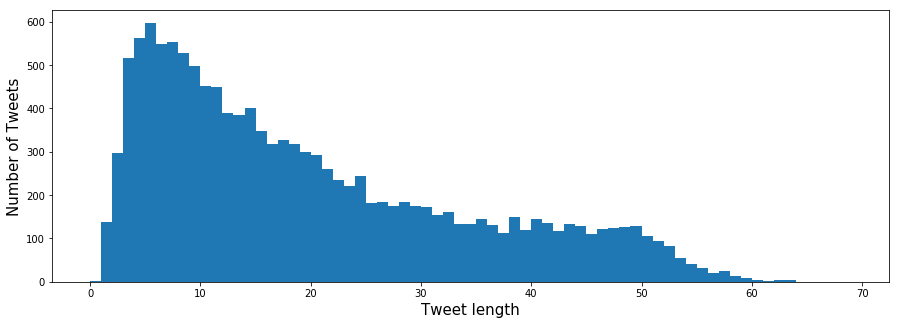

In [8]:
sentence_lengths = [len(tokens) for tokens in sequences]
print("Mean sentence length: {:0.1f} words".format(np.mean(sentence_lengths)))
print("MAX  sentence length: {} words".format(np.max(sentence_lengths)))

fig = plt.figure(figsize=(15, 5)) 
plt.xlabel('Tweet length', fontsize=15)
plt.ylabel('Number of Tweets', fontsize=15)
plt.hist(sentence_lengths, bins=list(range(70)))
plt.show()

# 2. BUILD MODEL & TRAIN

### Define RNN Models

In [9]:
def build_Bi_GRU_LSTM_CN_model(lr=0.001, lr_decay=0.01, recurrent_units=0, dropout=0.0):
    # Model architecture
    inputs = Input(shape = (max_seq_len,), name="Input")
    
    emb = Embedding(nb_words+1, embed_size, trainable=train_embeddings, name="WordEmbeddings")(inputs)
    emb = SpatialDropout1D(dropout)(emb)

    gru_out  = Bidirectional(CuDNNGRU(RECURRENT_UNITS, return_sequences = True), name="Bi_GRU")(emb)
    gru_out  = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(gru_out)

    lstm_out = Bidirectional(CuDNNLSTM(RECURRENT_UNITS, return_sequences = True), name="Bi_LSTM")(emb)
    lstm_out = Conv1D(32, 4, activation='relu', padding='valid', kernel_initializer='he_uniform')(lstm_out)

    avg_pool1 = GlobalAveragePooling1D(name="GlobalAVGPooling_GRU")(gru_out)
    max_pool1 = GlobalMaxPooling1D(name="GlobalMAXPooling_GRU")(gru_out)

    avg_pool2 = GlobalAveragePooling1D(name="GlobalAVGPooling_LSTM")(lstm_out)
    max_pool2 = GlobalMaxPooling1D(name="GlobalMAXPooling_LSTM")(lstm_out) 

    x = concatenate([avg_pool1, max_pool1, avg_pool2, max_pool2])

    outputs = Dense(1, activation='sigmoid', name="Output")(x)
    
    model = Model(inputs,outputs)
    
    return model, 1

def build_LSTM():
    model = Sequential()
    model.add(Embedding(nb_words+1, embed_size, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Bidirectional(CuDNNLSTM(RECURRENT_UNITS)))
    model.add(Dense(1, activation='sigmoid'))
    return model, 0

def build_CNN_LSTM():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
    model.add(SpatialDropout1D(DROPOUT))
    model.add(Conv1D(64, 4, activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Bidirectional(LSTM(RECURRENT_UNITS, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Dense(1, activation='sigmoid'))
    return model, 0

def build_LSTM_CNN():
    EMBEDDING_DIM = embed_size
    model = Sequential()
    model.add(Embedding(nb_words+1, EMBEDDING_DIM, input_length=max_seq_len, trainable=train_embeddings, name="Embeddings"))
#     model.add(SpatialDropout1D(DROPOUT))
    model.add(Dropout(DROPOUT))
    model.add(Bidirectional(CuDNNLSTM(RECURRENT_UNITS, return_sequences=True)))
#     model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences=True, dropout=LSTM_DROPOUT, recurrent_dropout=LSTM_DROPOUT)))
    model.add(Conv1D(64, kernel_size=2, activation='relu', padding='valid', kernel_initializer='he_uniform'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model, 0

### Build and Train

[0.004, 0, 20, 32, 100, 0.4, 0.0]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embeddings (Embedding)       (None, 50, 100)           1483200   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 1,645,001
Trainable params: 161,801
Non-trainable params: 1,483,200
_________________________________________________________________
Class weights (to address dataset imbalance):


{0: 0.748868778280543, 1: 1.5045454545454546}

Train on 13240 samples, validate on 320 samples
Epoch 1/20
13240/13240 [==============================] - 17s 1ms/step - loss: 0.5442 - acc: 0.7260 - val_loss: 0.3607 - val_acc: 0.8531

Epoch 00001: val_loss improved from inf to 0.36075, saving model to weights-improvement-01-0.85313-0.36075.hdf5
     - LR: 0.00400 train_auc: 0.7269 - train_F1: 0.7404 - val_auc: 0.7968 - val_F1: 0.7982


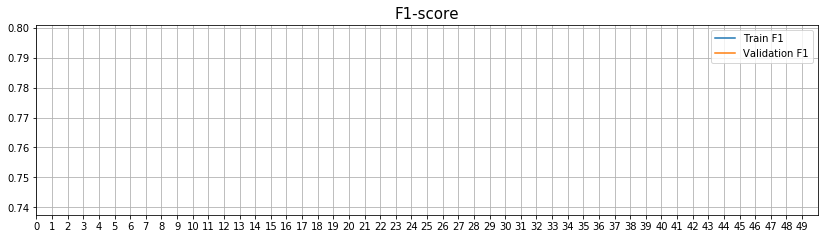




Epoch 2/20
13240/13240 [==============================] - 15s 1ms/step - loss: 0.4957 - acc: 0.7646 - val_loss: 0.3535 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.36075 to 0.35350, saving model to weights-improvement-02-0.87500-0.35350.hdf5
     - LR: 0.00400 train_auc: 0.7163 - train_F1: 0.7338 - val_auc: 0.8112 - val_F1: 0.8225


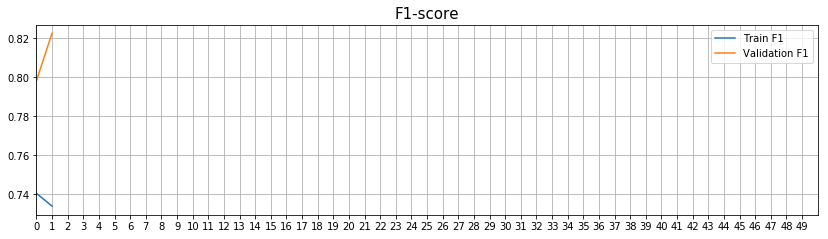




Epoch 3/20
13240/13240 [==============================] - 17s 1ms/step - loss: 0.4760 - acc: 0.7737 - val_loss: 0.3764 - val_acc: 0.8531

Epoch 00003: val_loss did not improve from 0.35350
     - LR: 0.00400 train_auc: 0.7580 - train_F1: 0.7705 - val_auc: 0.8101 - val_F1: 0.8033


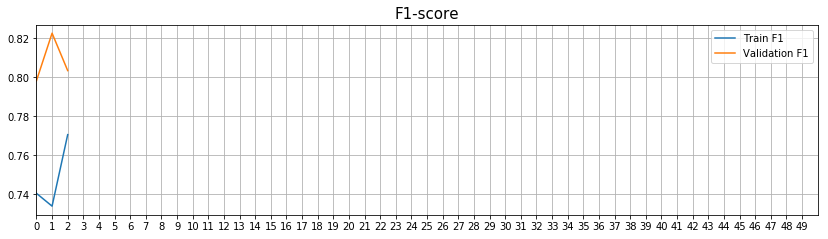




Epoch 4/20
13240/13240 [==============================] - 18s 1ms/step - loss: 0.4628 - acc: 0.7840 - val_loss: 0.3468 - val_acc: 0.8719

Epoch 00004: val_loss improved from 0.35350 to 0.34676, saving model to weights-improvement-04-0.87187-0.34676.hdf5
     - LR: 0.00400 train_auc: 0.7405 - train_F1: 0.7603 - val_auc: 0.8003 - val_F1: 0.8154


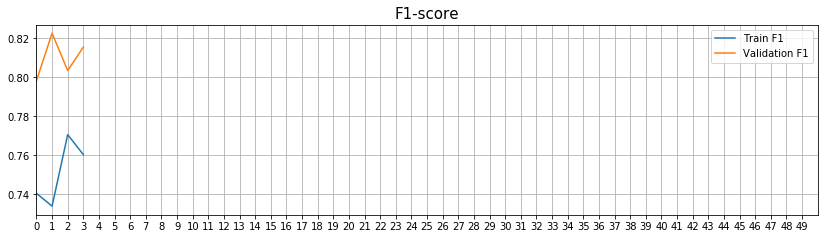




Epoch 5/20
 8800/13240 [==================>...........] - ETA: 5s - loss: 0.4487 - acc: 0.7947

KeyboardInterrupt: 

In [13]:
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

# SET HYPERPARAMETERS -------------------------------------------------------------------------------------------
LR               = 0.004
LR_DECAY         = 0
EPOCHS           = 20
BATCH_SIZE       = 32
EMBEDDING_DIM    = embed_size
DROPOUT          = 0.4         # Connection drop ratio for CNN to LSTM dropout
LSTM_DROPOUT     = 0.0         # Connection drop ratio for gate-specific dropout
BIDIRECTIONAL    = True
RECURRENT_UNITS  = 100
train_embeddings = not use_pretrained_embeddings
print([LR, LR_DECAY, EPOCHS, BATCH_SIZE, EMBEDDING_DIM, DROPOUT, LSTM_DROPOUT])
#---------------------------------------------------------------------------------------------------------------


# BUILD MODEL --------------------------------------------------------------------------------------------------
# - Can select which architecture to use (simple LSTM works pretty well)
model, embed_idx = build_LSTM()
# model, embed_idx = build_CNN_LSTM()
# model, embed_idx = build_LSTM_CNN()
# model, embed_idx = build_Bi_GRU_LSTM_CN_model(LR, LR_DECAY, RECURRENT_UNITS, DROPOUT)
#---------------------------------------------------------------------------------------------------------------


# OPTIMIZER | COMPILE | EMBEDDINGS -----------------------------------------------------------------------------
optim = optimizers.Adam(lr=LR, decay=LR_DECAY)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
if use_pretrained_embeddings:
    model.layers[embed_idx].set_weights([embedding_matrix])
model.summary()
#---------------------------------------------------------------------------------------------------------------
# X_train, X_val, y_train, y_val = (X, y, X_trial, Y_trial)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Can change right hand side to (X, y, X_trial, y_trial) or (X_train, Y_train, X_val, Y_val)
X_train, y_train, X_val, y_val = (X, y, X_trial, y_trial)

class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train), y_train.reshape(-1))
weights_dict = dict()
for i, weight in enumerate(class_weights):
    weights_dict[i] = weight
print("Class weights (to address dataset imbalance):")
display(weights_dict)


# FIT THE MODEL ------------------------------------------------------------------------------------------------
auc_f1     = ROC_F1(validation_data=(X_val, y_val), training_data=(X_train, y_train), interval=1)
earlystop  = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto', restore_best_weights=True)
filepath   = "weights-improvement-{epoch:02d}-{val_acc:.5f}-{val_loss:.5f}.hdf5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', verbose=1, mode='min')

train_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS,
                          verbose=1, callbacks=[earlystop, checkpoint, auc_f1])
#---------------------------------------------------------------------------------------------------------------

### Evaluate [Training History, Classification Report + Metrics]


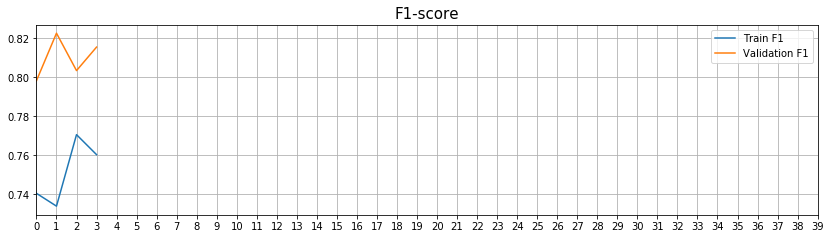

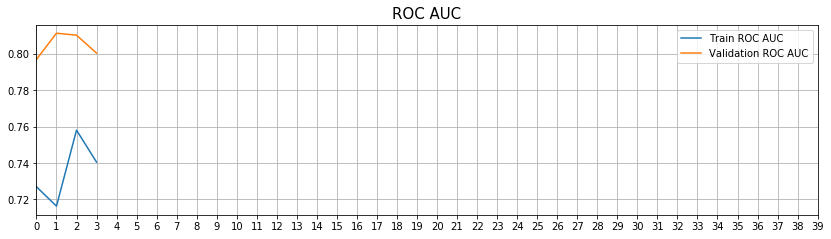

Validation Accuracy: 84.69%
Normalized confusion matrix
[[0.88065844 0.11934156]
 [0.25974026 0.74025974]]


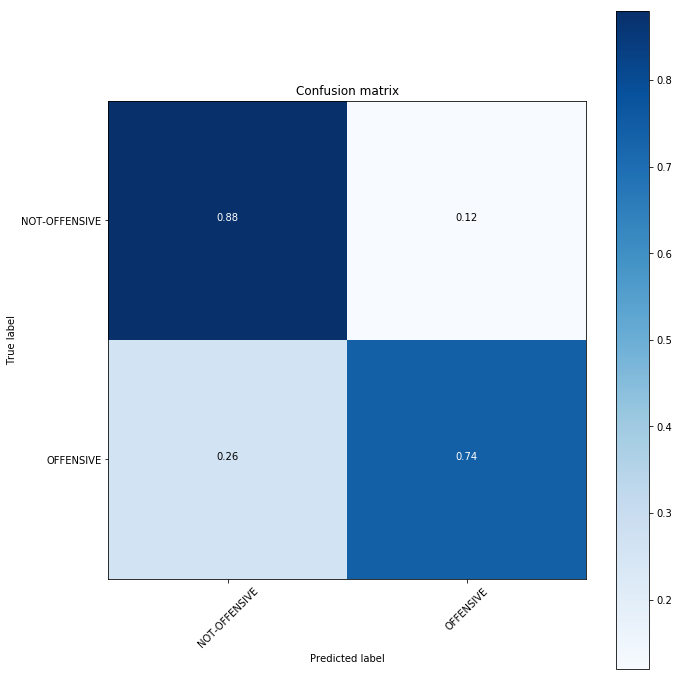

              precision    recall  f1-score   support

           0       0.91      0.88      0.90       243
           1       0.66      0.74      0.70        77

   micro avg       0.85      0.85      0.85       320
   macro avg       0.79      0.81      0.80       320
weighted avg       0.85      0.85      0.85       320



In [15]:
height = 3.5;    width = height*4
n_epochs = 40
# n_epochs = len(train_history.history['loss'])

# # Plot Loss
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['loss'], label="Train Loss")
# plt.plot(train_history.history['val_loss'], label="Validation Loss")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Loss (Binary Cross-entropy)", fontsize=15)
# plt.show()

# # Plot accuracy
# plt.figure(figsize=(width,height))
# plt.plot(train_history.history['acc'], label="Train Accuracy")
# plt.plot(train_history.history['val_acc'], label="Validation Accuracy")
# plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
# plt.title("Accuracy", fontsize=15)
# plt.show()

# Plot F1
plt.figure(figsize=(width,height))
plt.plot(auc_f1.f1s_train, label="Train F1")
plt.plot(auc_f1.f1s_val, label="Validation F1")
plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
plt.title("F1-score", fontsize=15)
plt.show()

# # Plot ROC AUC
plt.figure(figsize=(width,height))
plt.plot(auc_f1.aucs_train, label="Train ROC AUC")
plt.plot(auc_f1.aucs_val, label="Validation ROC AUC")
plt.xlim([0,n_epochs-1]); plt.xticks(list(range(n_epochs)));   plt.grid(True);   plt.legend()
plt.legend()
plt.title("ROC AUC", fontsize=15)
plt.show()

##### Confusion matrix & Classication Report ###################################################
import itertools
from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.winter):
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, fontsize=30)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, fontsize=20)
#     plt.yticks(tick_marks, classes, fontsize=20)
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.

#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
#                  color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
#     plt.tight_layout()
#     plt.ylabel('True label', fontsize=30)
#     plt.xlabel('Predicted label', fontsize=30)

#     return plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

X_eval = X_trial
y_eval = y_trial

y_pred = model.predict(X_eval)
y_pred = np.round(y_pred)
print("Validation Accuracy: {:0.2f}%".format(np.sum(y_eval==y_pred)/y_eval.shape[0]*100))

cm = confusion_matrix(y_eval, y_pred)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['NOT-OFFENSIVE','OFFENSIVE'], normalize=True, title='Confusion matrix')
plt.show()
# print(cm)


from sklearn.metrics import classification_report
print(classification_report(y_eval, y_pred))

## Generate Submission

In [18]:
model.save("model_A.h5")
params = dict(remove_USER_URL=True,
              remove_stopwords=False,
              remove_HTMLentities=True,
              remove_punctuation=True,
              appostrophe_handling=True,
              lemmatize=True)

df_test = pd.read_csv('../OffensEval_data/test/testset-taska.tsv',sep='\t')
ID = df_test['id']

X_test = df_test['tweet'].apply(lambda x: process_tweet(x, **params, trial=False)).values

sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen = max_seq_len)

y_pred = model.predict(X_test)

OFF = y_pred
NOT = 1-y_pred
Y_pred = np.hstack((NOT, OFF))

classes = np.argmax(Y_pred, axis=1).reshape(-1,1)

df_submission = pd.DataFrame()
df_submission['id'] = ID
df_submission['label'] = classes
df_submission['label'] = df_submission['label'].replace({0: 'NOT', 1: 'OFF'})

df_submission.head()
df_submission.to_csv("submission_a/test_a_submission.csv", header=None, index=None)

(860, 50)

array([[0.6547883 , 0.34521168],
       [0.8805501 , 0.11944994],
       [0.9181634 , 0.08183661],
       ...,
       [0.08649457, 0.91350543],
       [0.73447204, 0.265528  ],
       [0.6436661 , 0.3563339 ]], dtype=float32)

(860, 1)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
    

In [ ]:
# TO USE TWITTER GLOVE EMBEDDINGS ##########################
# https://nlp.stanford.edu/projects/glove/
# https://nlp.stanford.edu/data/glove.twitter.27B.zip

# PRE-PROCESS
import re
def glove_preprocess(text):
    """
    adapted from https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
    """
    # Different regex parts for smiley faces
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r'http\S+', '<URL> ', text)
    text = re.sub(r'@\S+', '<USER>', text)
    text = re.sub("www.* ", "<URL>", text)
    text = re.sub("\[\[User(.*)\|", '<USER>', text)
    text = re.sub("<3", r'<HEART> ', text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub(eyes + nose + "[Dd)]", '<SMILE>', text)
    text = re.sub("[(d]" + nose + eyes, '<SMILE>', text)
    text = re.sub(eyes + nose + "p", '<LOLFACE>', text)
    text = re.sub(eyes + nose + "\(", '<SADFACE>', text)
    text = re.sub("\)" + nose + eyes, '<SADFACE>', text)
    text = re.sub(eyes + nose + "[/|l*]", '<NEUTRALFACE>', text)
    text = re.sub("/", " / ", text)
    text = re.sub("[-+]?[.\d]*[\d]+[:,.\d]*", "<NUMBER>", text)
    text = re.sub("([!]){2,}", "! <REPEAT>", text)
    text = re.sub("([?]){2,}", "? <REPEAT>", text)
    text = re.sub("([.]){2,}", ". <REPEAT>", text)
    pattern = re.compile(r"(.)\1{2,}")
    text = pattern.sub(r"\1" + " <ELONG>", text)
    return text

In [ ]:
text = "@handermoren you are an absolute moron ???????? idiot 6 :( :p :) https://google.es"
print(text)
text = glove_preprocess(text)
print(text)